In [23]:
!pip install catboost optuna

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, accuracy_score, roc_auc_score

In [25]:
# ==========================================
# 1. DATA LOADING & CLEANING
# ==========================================
print("[1] Loading Data...")
df = pd.read_csv('HR-Employee-Attrition.csv')

df.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis=1, inplace=True, errors='ignore')

df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

[1] Loading Data...


In [26]:
# ==========================================
# 2. FEATURE ENGINEERING (Fokus Fitur Kuat)
# ==========================================
print("[2] Feature Engineering...")

df['TotalSatisfaction'] = df['JobSatisfaction'] + df['EnvironmentSatisfaction'] + df['RelationshipSatisfaction'] + df['JobInvolvement']

df['YearsAtCompany'] = df['YearsAtCompany'].replace(0, 0.1)
df['YearsInCurrentRole'] = df['YearsInCurrentRole'].replace(0, 0.1)

df['CareerStability'] = df['YearsInCurrentRole'] / df['YearsAtCompany']
df['LoyaltyRatio'] = df['YearsAtCompany'] / df['TotalWorkingYears'].replace(0, 1)

# overwork tanpa pay raise
df['IncomePerAge'] = df['MonthlyIncome'] / df['Age']

drop_cols = ['Gender', 'PerformanceRating', 'DailyRate', 'HourlyRate', 'MonthlyRate', 'PercentSalaryHike']
df.drop(drop_cols, axis=1, inplace=True, errors='ignore')

[2] Feature Engineering...


In [27]:
# ==========================================
# 3. PREPROCESSING
# ==========================================
print("[3] Preprocessing for CatBoost...")

X = df.drop('Attrition', axis=1)
y = df['Attrition']

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_features:
    X[col] = X[col].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

[3] Preprocessing for CatBoost...


In [28]:
# ==========================================
# 4. OPTUNA DENGAN CROSS-VALIDATION
# ==========================================
import numpy as np
import random
import optuna

seed = 42

np.random.seed(seed)
random.seed(seed)

print("\n[4] Tuning Hyperparameter dengan Optuna (Fokus Accuracy & Stability)...")

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 8),
        'random_seed': seed,
        'task_type': 'CPU',
        'thread_count': 1,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 3.5),
        'loss_function': 'Logloss',
        'eval_metric': 'Recall',
        'verbose': False,
        'cat_features': categorical_features,
        'early_stopping_rounds': 50,
        'bootstrap_type': 'Bernoulli',
        'subsample': 1.0
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    cv_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=10, verbose=False)

        preds = model.predict(X_val)
        cv_scores.append(accuracy_score(y_val, preds))

    return np.mean(cv_scores)

sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

print("\nBest CV Accuracy:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-12-04 03:47:02,375] A new study created in memory with name: no-name-5e1db9f4-9b2e-419e-905f-4c395d5bc662



[4] Tuning Hyperparameter dengan Optuna (Fokus Accuracy & Stability)...


[I 2025-12-04 03:47:02,838] Trial 0 finished with value: 0.8571428571428572 and parameters: {'iterations': 275, 'learning_rate': 0.09556428757689246, 'depth': 7, 'l2_leaf_reg': 7.190609389379256, 'scale_pos_weight': 1.3900466011060912}. Best is trial 0 with value: 0.8571428571428572.
[I 2025-12-04 03:47:03,528] Trial 1 finished with value: 0.8375850340136054 and parameters: {'iterations': 231, 'learning_rate': 0.015227525095137952, 'depth': 8, 'l2_leaf_reg': 7.207805082202461, 'scale_pos_weight': 2.7701814444901136}. Best is trial 0 with value: 0.8571428571428572.
[I 2025-12-04 03:47:04,140] Trial 2 finished with value: 0.8324829931972788 and parameters: {'iterations': 204, 'learning_rate': 0.0972918866945795, 'depth': 8, 'l2_leaf_reg': 4.486373774747933, 'scale_pos_weight': 1.4545624180177517}. Best is trial 0 with value: 0.8571428571428572.
[I 2025-12-04 03:47:04,635] Trial 3 finished with value: 0.8443877551020408 and parameters: {'iterations': 236, 'learning_rate': 0.03738180186635


Best CV Accuracy: 0.8622448979591836
Best Params: {'iterations': 296, 'learning_rate': 0.06644886321664556, 'depth': 7, 'l2_leaf_reg': 8.529759819719331, 'scale_pos_weight': 1.2733339030000708}



[5] Final Training & Evaluation...
0:	learn: 0.6499875	test: 0.6485391	best: 0.6485391 (0)	total: 19.6ms	remaining: 5.78s
100:	learn: 0.1950874	test: 0.3769820	best: 0.3712541 (61)	total: 1.9s	remaining: 3.66s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.371254099
bestIteration = 61

Shrink model to first 62 iterations.

Optimizing Cutoff Threshold...

Best Threshold Found: 0.279
F1-score at Best Threshold: 0.5714

================= FINAL MODEL REPORT =================
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       247
           1       0.52      0.64      0.57        47

    accuracy                           0.85       294
   macro avg       0.72      0.76      0.74       294
weighted avg       0.86      0.85      0.85       294



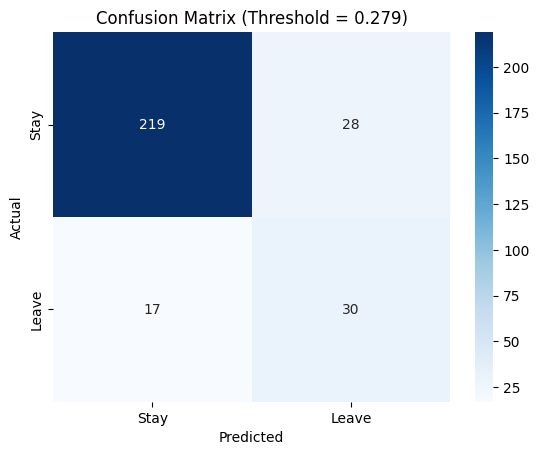


ROC AUC Score: 0.8371


In [29]:
# ==========================================
# 5. FINAL TRAINING & EVALUATION
# ==========================================
print("\n[5] Final Training & Evaluation...")

best_params = study.best_params
best_params['cat_features'] = categorical_features
best_params['verbose'] = 100

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

print("\nOptimizing Cutoff Threshold...")

y_prob = final_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"\nBest Threshold Found: {best_threshold:.3f}")
print(f"F1-score at Best Threshold: {f1_scores[best_idx]:.4f}")

y_pred_thresh = (y_prob >= best_threshold).astype(int)

print("\n================= FINAL MODEL REPORT =================")
print(classification_report(y_test, y_pred_thresh))

cm = confusion_matrix(y_test, y_pred_thresh)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stay', 'Leave'],
            yticklabels=['Stay', 'Leave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.3f})')
plt.show()

auc_score = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {auc_score:.4f}")

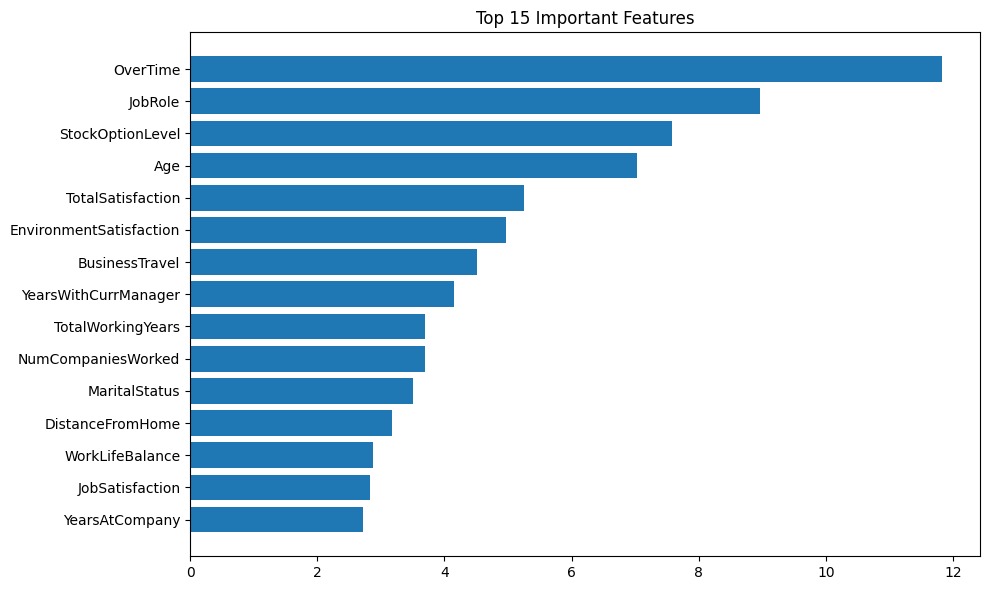


Model saved as catboost_optimized.cbm
✓ feature_names.pkl berhasil disimpan! (Siap untuk Streamlit)


In [30]:
# ==========================================
# 6. FEATURE IMPORTANCE (Untuk Insight)
# ==========================================
feature_importance = final_model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)[-15:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Top 15 Important Features')
plt.tight_layout()
plt.show()

# Simpan Model
final_model.save_model("catboost_optimized.cbm")
print("\nModel saved as catboost_optimized.cbm")

import pickle
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

print("✓ feature_names.pkl berhasil disimpan! (Siap untuk Streamlit)")

In [31]:
# ==========================================
# 7. EXPORT FINAL CSV UNTUK NEO4J (FULL EXPORT)
# ==========================================
print("\n[7] Exporting FULL Neo4j CSV...")

X_full = X.copy()
y_full_prob = final_model.predict_proba(X_full)[:, 1]
y_full_pred = (y_full_prob >= best_threshold).astype(int)

df_export = df.copy()

df_export["AttritionRisk"] = y_full_prob
df_export["Prediction"] = y_full_pred

df_export.insert(0, "EmployeeID", range(1, len(df_export) + 1))

df_export.to_csv("final_employee_data.csv", index=False)

print("✓ final_employee_data.csv (FULL EXPORT) berhasil dibuat!")



[7] Exporting FULL Neo4j CSV...
✓ final_employee_data.csv (FULL EXPORT) berhasil dibuat!


# Query Neo4j

Load CSV + add EmployeeID berdasar row number

```
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/citylighxts/analisis-attrition/refs/heads/main/final_employee_data.csv' AS row
MERGE (e:Employee {EmployeeID: toInteger(row.EmployeeID)})
SET  e.Age = toInteger(row.Age),
     e.MonthlyIncome = toInteger(row.MonthlyIncome),
     e.TotalWorkingYears = toInteger(row.TotalWorkingYears),
     e.OverTime = row.OverTime,
     e.Department = row.Department,
     e.JobRole = row.JobRole,
     e.BusinessTravel = row.BusinessTravel,
     e.MaritalStatus = row.MaritalStatus,
     e.DistanceFromHome = toInteger(row.DistanceFromHome),
     e.Education = toInteger(row.Education),
     e.EducationField = row.EducationField,
     e.TotalSatisfaction = toInteger(row.TotalSatisfaction),
     e.CareerStability = toFloat(row.CareerStability),
     e.LoyaltyRatio = toFloat(row.LoyaltyRatio),
     e.IncomePerAge = toFloat(row.IncomePerAge),
     e.AttritionRisk = toFloat(row.AttritionRisk),
     e.Prediction = toInteger(row.Prediction);
```

Membuat node Department
```
MATCH (e:Employee)
WITH DISTINCT e.Department AS dept
MERGE (:Department {name: dept});
```

Membuat node JobRole
```
MATCH (e:Employee)
WITH DISTINCT e.JobRole AS role
MERGE (:JobRole {name: role});
```

Membuat relasi WORKS_IN

```
MATCH (e:Employee)
MATCH (d:Department {name: e.Department})
MERGE (e)-[:WORKS_IN]->(d);
```

Membuat relasi HAS_ROLE
```
MATCH (e:Employee)
MATCH (r:JobRole {name: e.JobRole})
MERGE (e)-[:HAS_ROLE]->(r);
```

List 10 Employee dengan AttritionRisk tertinggi

```
MATCH (e:Employee)
RETURN e.EmployeeID, e.JobRole, e.Department, e.AttritionRisk
ORDER BY e.AttritionRisk DESC
LIMIT 10;
```


Jumlah pegawai tiap departemen yang memiliki High AttritionRisk

Berdasarkan model, threshold-nya adalah 0.279

```
MATCH (e:Employee)-[:WORKS_IN]->(d:Department)
WHERE e.AttritionRisk >= 0.279
RETURN d.name AS Department,
       COUNT(e) AS HighRiskEmployees
ORDER BY HighRiskEmployees DESC;
```

List pegawai yang memiliki AttritionRisk tinggi

```
MATCH (e:Employee)-[:WORKS_IN]->(d:Department)
MATCH (e)-[:HAS_ROLE]->(r:JobRole)
WHERE e.AttritionRisk >= 0.279
RETURN d.name AS Department,
       r.name AS JobRole,
       e.EmployeeID,
       e.AttritionRisk
ORDER BY e.AttritionRisk DESC;
```

Rata-rata AttritionRisk karyawan yang lembur dan tidak lembur

```
MATCH (e:Employee)
WITH e.OverTime AS OT, COUNT(*) AS total, AVG(e.AttritionRisk) AS avgRisk
RETURN OT, total, avgRisk
ORDER BY avgRisk DESC;
```


Role dengan AttritionRisk tertinggi
```
MATCH (e:Employee)-[:HAS_ROLE]->(j:JobRole)
RETURN j.name AS JobRole,
       COUNT(e) AS TotalEmployees,
       AVG(e.AttritionRisk) AS AvgRisk
ORDER BY AvgRisk DESC;
```